In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim):
        super(PolicyNetwork, self).__init__()
        layers = []
        prev_size = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(prev_size, hs))
            layers.append(nn.ReLU())
            prev_size = hs
        layers.append(nn.Linear(prev_size, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        logits = self.model(x)
        return torch.softmax(logits, dim=-1)


class ValueNetwork(nn.Module):
    def __init__(self, input_dim, hidden_sizes):
        super(ValueNetwork, self).__init__()
        layers = []
        prev_size = input_dim
        for hs in hidden_sizes:
            layers.append(nn.Linear(prev_size, hs))
            layers.append(nn.ReLU())
            prev_size = hs
        layers.append(nn.Linear(prev_size, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [9]:
def actor_critic(env,
              input_dim,
              output_dim,
              hidden_sizes,
              alpha=0.001,
              beta=0.001,
              episodes=500,
              gamma=0.99,
              log_dir="runs/reinforce_with_baseline"):
    """
    REINFORCE training loop with a baseline (value function).

    Args:
        env: OpenAI gym environment
        input_dim: dimension of input space
        output_dim: number of actions
        hidden_sizes: list of sizes for each hidden layer
        alpha: The learning rate for the policy network
        beta: The learning rate for the value network
        episodes: number of training episodes
        gamma: discount factor
        log_dir: directory for tensorboard logs

    Returns:
        policy_network: the trained policy network
        rewards_per_episode: a list containing the total reward per episode
    """

    writer = SummaryWriter(log_dir=log_dir)

    policy_network = PolicyNetwork(input_dim, hidden_sizes, output_dim).to(device)
    value_network = ValueNetwork(input_dim, hidden_sizes).to(device)

    policy_optimizer = optim.Adam(policy_network.parameters(), lr=alpha)
    value_optimizer = optim.Adam(value_network.parameters(), lr=beta)

    rewards_per_episode = []

    for episode in range(episodes):
        # generate a new episode
        state, _ = env.reset()
        done = False
        states = []
        actions_log_probs = []
        rewards = []

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action_probs = policy_network(state_tensor)
            action_dist = torch.distributions.Categorical(action_probs)
            action = action_dist.sample()
            log_prob = action_dist.log_prob(action)

            next_state, reward, done, truncated, info = env.step(action.item())

            states.append(state)
            actions_log_probs.append(log_prob)
            rewards.append(reward)

            state = next_state

        # compute the returns (G_t) for the episode (including gamma)
        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.append(G)
        returns.reverse()

        states_tensor = torch.tensor(np.array(states), dtype=torch.float32, device=device)
        returns_tensor = torch.tensor(returns, dtype=torch.float32, device=device).unsqueeze(1)

        # compute value predictions
        values = value_network(states_tensor)

        # compute advantages A_t = G_t - V(s_t)
        advantages = returns_tensor - values.detach()

        # update policy network
        policy_loss = []
        for log_prob, A in zip(actions_log_probs, advantages):
            policy_loss.append(-log_prob * A)
        policy_loss = torch.cat(policy_loss).sum()

        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        # update value network (MSE loss between returns and values)
        value_loss = nn.MSELoss()(values, returns_tensor)
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        total_reward = sum(rewards)
        rewards_per_episode.append(total_reward)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}")

        # log metrics to TensorBoard
        writer.add_scalar("Policy Loss", policy_loss.item(), episode)
        writer.add_scalar("Value Loss", value_loss.item(), episode)
        writer.add_scalar("Total Reward", total_reward, episode)

        # early stopping if solved
        if len(rewards_per_episode) >= 100 and np.mean(rewards_per_episode[-100:]) >= 475.0:
            print(f"Solved in {episode + 1} episodes!")
            break

    writer.close()
    return policy_network, value_network, rewards_per_episode

In [10]:
def test_policy(env, policy_network, episodes=10):
    policy_network.eval()
    avg_reward = 0
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action_probs = policy_network(state_tensor)
            action = torch.argmax(action_probs).item()
            state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            if total_reward >= 10000:
                break

        avg_reward += total_reward
        print(f"Test Episode {ep + 1}, Total Reward: {total_reward}")
    return avg_reward / episodes

Episode 1/2000, Total Reward: 14.0
Episode 2/2000, Total Reward: 30.0
Episode 3/2000, Total Reward: 12.0
Episode 4/2000, Total Reward: 74.0
Episode 5/2000, Total Reward: 42.0
Episode 6/2000, Total Reward: 20.0
Episode 7/2000, Total Reward: 14.0
Episode 8/2000, Total Reward: 11.0
Episode 9/2000, Total Reward: 55.0
Episode 10/2000, Total Reward: 60.0
Episode 11/2000, Total Reward: 14.0
Episode 12/2000, Total Reward: 12.0
Episode 13/2000, Total Reward: 12.0
Episode 14/2000, Total Reward: 16.0
Episode 15/2000, Total Reward: 19.0
Episode 16/2000, Total Reward: 38.0
Episode 17/2000, Total Reward: 16.0
Episode 18/2000, Total Reward: 15.0
Episode 19/2000, Total Reward: 15.0
Episode 20/2000, Total Reward: 60.0
Episode 21/2000, Total Reward: 16.0
Episode 22/2000, Total Reward: 15.0
Episode 23/2000, Total Reward: 27.0
Episode 24/2000, Total Reward: 43.0
Episode 25/2000, Total Reward: 16.0
Episode 26/2000, Total Reward: 58.0
Episode 27/2000, Total Reward: 23.0
Episode 28/2000, Total Reward: 15.0
E

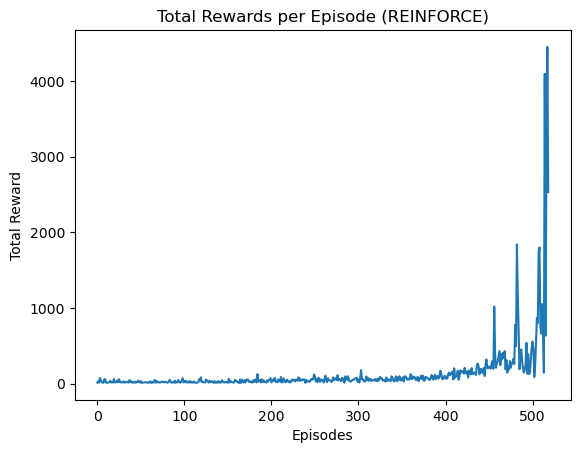

In [11]:
env = gym.make("CartPole-v1")

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
hidden_sizes = [16, 32, 16]

episodes = 2000
gamma = 0.99
alpha = 0.001

policy_network, value_network, rewards = actor_critic(env, input_dim=input_dim, output_dim=output_dim, hidden_sizes=hidden_sizes,
                                    alpha=alpha, episodes=episodes, gamma=gamma)

# plot the rewards
plt.figure()
plt.plot(rewards)
plt.title("Total Rewards per Episode (REINFORCE)")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.show()

In [12]:
# test the trained policy
print("Testing the policy...")
test_avg_reward = test_policy(env, policy_network, episodes=100)
print(f"Average Test Reward: {test_avg_reward}")

Testing the policy...
Test Episode 1, Total Reward: 10000.0
Test Episode 2, Total Reward: 10000.0
Test Episode 3, Total Reward: 10000.0
Test Episode 4, Total Reward: 10000.0
Test Episode 5, Total Reward: 10000.0
Test Episode 6, Total Reward: 10000.0
Test Episode 7, Total Reward: 10000.0
Test Episode 8, Total Reward: 10000.0
Test Episode 9, Total Reward: 10000.0
Test Episode 10, Total Reward: 10000.0
Test Episode 11, Total Reward: 10000.0
Test Episode 12, Total Reward: 10000.0
Test Episode 13, Total Reward: 10000.0
Test Episode 14, Total Reward: 10000.0
Test Episode 15, Total Reward: 10000.0
Test Episode 16, Total Reward: 10000.0
Test Episode 17, Total Reward: 10000.0
Test Episode 18, Total Reward: 10000.0
Test Episode 19, Total Reward: 10000.0
Test Episode 20, Total Reward: 10000.0
Test Episode 21, Total Reward: 10000.0
Test Episode 22, Total Reward: 10000.0
Test Episode 23, Total Reward: 10000.0
Test Episode 24, Total Reward: 10000.0
Test Episode 25, Total Reward: 10000.0
Test Episode

In [13]:
# save the policy and value networks
torch.save(policy_network.state_dict(), 'actor_critic_policy.pth')
torch.save(value_network.state_dict(), 'actor_critic_value.pth')